# Solution to Data Science Test

### Table of Contents

* [Introduction](#introduction)
* [Definition of the Problem](#definition)
* [Solutions Roadmap](#roadmap)
    * [Models](#models)
    * [Metrics](#metrics)
    * [Benchmark](#metrics)
* [Implementation](#implementation)
    * [Data Preprocessing](#preparation)
        * [Feature Engineering](#engineering)
        * [Missing Values](#missing)
        * [Ouliers](#outliers)
    * [Feature Selection](#selection)
    * [Traning](#traintest)
        * [Exploring the Hyperparameter Space](#space)
        * [Hyperparameter Tuning](#tuning)
    * [Testing](#results)
* [Results Analysis](#analysis)
    * [Feature Importance](#importance)
    * [Probabilities and Percentiles](#probs)
    * [Behavioural Patterns](#patterns)
* [Appendix](#appendix)

## Introduction <a class="anchor" id="introduction"></a>

This notebook presents the solution to the Data Science Test in depth. I build a XGBoost model to predict customer churning for CompanyX. Nested cross-validation reported an F1 of 0.877 and a ROC-AUC of 0.925, on average. The model was able to correctly identify **all** the churning cases from previously unseen data (17 out of 99 observations) and only one non-churning case (out of 82) was mistakenly classified as churning. Hence F1 over the testing set was of 0.97 (precision was equal to 1 and recall to 0.94). Feature importance extracted from the model suggests that activity pertaining to Process C is crucial to separate churning from non-churning customers, and I confirm it by analysing churning probabilities and user behaviour over time.   

The rest of this document is structed as follows. First, I define the problem as I understood it, in order to define the scope of interpretations that can be made out of the model. Next, I delineate the solution's roadmap, justifying the choice of modelling framework, metrics and benchmark. Then, I describe model implementation in detail, including data preprocessing, feature selection, training and testing. Finally, I analyse the results, giving insights and recommendations that emerge from my discoveries. 


## Definition of the Problem <a class="anchor" id="definition"></a>

In this section, I define the problem more precisely. It is important that I communicate what I understood from the process I modelled, so that the scope of my analysis and recommendations are clear. What I present here was interpreted from the product guides and the problem's description.

The picture below summarizes my understanding. It is a macro view on all the elements that work together to detect infringements:

![](flow.png)

At the start of a contract, a scraping engine scans web pages with relevant content (potential infringements) and send them to the machine learning pipeline. Feeding of web documents is continuous over contract duration. After ingesting these documents, the pipeline runs a classification algorithm which is able to calculate the probabilities (identification scores) of a certain page/domain being an infringement. Based on these identification scores, the algorithm is able to separate the cases (potential infringements) into three categories: low risk of being an infringement (A), mid risk (B), and high risk (C). 

These results are sent to the user application. Then the user, via interface, validates model's outcomes by making the following decisions:

1. *Process A*: Low risk cases are either **definitely not** an infringement (A = false), or **probably is** an infringement (A = true; the user is not sure and might create an automation rule for cases like that to be labeled as mid risk from the start), or  **definitely is** an infringement.
2. *Process B*: Mid risk cases are either **definitely not** an infringement (B = false), or **probably is** an infringement (B = true; the user is not sure and might create an automation rule for cases like that to be labeled as high risk from the start), or  **definitely is** an infringement.
3. *Process C*: High risk cases are either **definitely not** an infringement (C = false), or **definitely is** an infringement (C = true).

Whenever the user decides that a case is definitely an infringement, s/he might create an automation rule to label that case as an infringement from the start or the software might do it automatically. Also, when the user is not sure about a case, the case is labeled with the next risk level (A->B->C), appearing at the corresponding validation process. 

While validation is happening, misclassifications (cases labeled as **not** an infringement by the user, but the inverse by the algorithm) are sent back to the machine learning model, so that it learns from errors. Finally, at some point, the user validates the last batch of cases (contract ends).

Many elements that I mentioned actually seem to work in parallel and to interact in more complex ways. This is especially true for the validation system, highlighted by the dashed line in the picture above. To illustrate my understanding of that subsystem in particular, I created an UML Sequence diagram representing a use case, displayed below.

![](umls.png)

In this diagram, I represent a single user, assuming s/he validates lower risk cases before higher risk cases (the order doesn't matter). The point is that feedback from the user to the model, validation, and feedback from the model to the user all occur at the same time (the dashed line inside the frame named *parallel* demarks parallel processes). 

Assuming that the whole system works like that, I investigated the specific causes that makes CompanyX's customers satisfied and what are the possible reasons behind churning. At the beginning, it was useful to think about the problem in this way: users that find more infringements as a proportion of total potential cases presented to him/her are probably happier (the system is effective and saves them time). But there is much more to it. By analysing model's outputs, I was able to pinpoint which processes and interactions were most likely driving churning.


## Solution's Roadmap <a class="anchor" id="roadmap"></a>

### Models <a class="anchor" id="models"></a>

In order to choose modelling frameworks that could help solving the problem at hand, I often think about constraints imposed by the data. As I show in section [Data Preprocessing](#preparation), the final dataset had the following properties:

* Few data points (around 600 from origninally 17k+). Models that support it naturally: SVM, Naive Bayes, Ensembles (e.g. XGBoost).
* Class imbalance of 6:1. Undersampling was not an option because I would end up with too few data points, while oversampling would probably not work considering the size of the dataset and the severity of imbalance. Models that handle imbalance through weights: SVM, Logistic Regression, and XGBoost in some cases.

From this list, we see that SVM, Logistic Regression and XGBoost are the best options. My strategy with those models, based on previous experience with their accuracy, computational time, and complexities, was:

1. Build an optimized Logistic Regression. If results are not satisfactory, save this model and move on to the next step. Otherwise, stop and use it for analysis. Simple models should be preferred over complex ones and there's nothing simpler than a linear model.
2. Build an optimized XGBoost. If results are satisfactory, stop and use it for analysis, since it's difficult to beat XGBoost in classification problems. Otherwise, try SMOTE. If results are not satisfactory, save this model and move on to the next step.
3. Build an optimized SVM. If results are not satisfactory, save this model and move on to the next step. Otherwise, stop and use it for analysis. 
4. Take the majority vote from the three previous weak classifiers. Most likely, combining the responses of these uncorrelated models will decrease variance (overfitting) while preserving or incresing the bias (accuracy).

As I will show in section [Models](#models), I only needed to go as far as step 2 to obtain an excellent classifier, without SMOTE.

### Metrics <a class="anchor" id="metrics"></a>

Metrics must be meaningful in terms of the outcome we desire. Accuracy would not work well here, since it could simply reflect the fact that the model is predicting which customers are not going to churn (the majority case). ROC-AUC is always a good reference, but there are better metrics for our problem, such as:

* Precision: We need to make sure we're catching as many churning customers as possible. False positives are not so important. But they are costly. We don't want to target them with expensive marketing, offers or training. 
* Recall: We need to make sure that if we're classifying a customer as churning, he's really a churning customer, because targeting them might be expensive. But, sometimes, we're better safe than sorry.

Considering this, I chose F1 as the target metric for optimising my models, since it is a balance between precision and recall.

### Benchmark  <a class="anchor" id="benchmarks"></a>

The benchmark model was the weak classifier obtained from an optmized Logistic Regression model, as decribed [here](#models).

## Implementation <a class="anchor" id="implementation"></a>

In this section we will cover the final model's implementation and design, from data preprocessing to results. We selected the XGBoost framework for its outstanding performance relative to Logistic Regression (and, in fact, according to any reasonable criteria). Details about the implementation of this benchmark model can be found in the [Appendix](#appendix).

For the code to work properly, the following libraries are necessary and configurations below them are optional, but recommended: 

In [67]:
import warnings
from IPython.core.display import display, HTML

# Date and Time
import time
from datetime import datetime

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Math and Stats
import numpy as np
import scipy.stats as ss
import math

# Data Manipulation
import pandas as pd
import itertools

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

# Scikit-Learn
import sklearn.metrics as sklm
import sklearn.preprocessing as pp
from sklearn import model_selection as ms
from sklearn.feature_selection import RFE

# Personal library
import custom_manip as cm
import custom_plots as cp
import custom_algrt as ca 

pd.set_option('display.max_rows', None)
np.random.seed(2345)
warnings.simplefilter("ignore")

Notice that I import *custom_manip* as *cm*, *custom_plots* as *cp*, and *custom_algrt* as *ca*. They contain functions that are part of my personal library for data manipulation, plotting, and machine learning. I will use them throughout the modelling process.

## Data Preprocessing <a class="anchor" id="preparation"></a>

We first take a brief look at the main table, which I call *customer* table:

In [2]:
customer = pd.read_csv('test_dataset.csv', sep = ';').iloc[:,1:]
customer.head()

,customer,contractid,year,quarter,month,contract_type,startdate,enddate,is_active,A_true,...,BORRAR_4,BORRAR_5,BORRAR_6,BORRAR_7,avg_B_true_C_false,automatization_A,automatization_B,automatization_C,BORRAR_8,B_false
0,393,16,2019,4,12,Piracy,1515456000000,NaN,active,1198.0,...,NaN,NaN,42.0,46.0,45.0,0.35,NaN,NaN,NaN,NaN
1,393,16,2020,3,8,Piracy,1515456000000,NaN,active,7250.0,...,NaN,NaN,1.0,1.0,NaN,0.98,NaN,NaN,NaN,NaN
2,393,16,2020,1,3,Piracy,1515456000000,NaN,active,803.0,...,NaN,NaN,0.0,0.0,NaN,0.28,NaN,NaN,NaN,NaN
3,393,16,2018,3,7,Piracy,1515456000000,NaN,active,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,393,16,2020,3,9,Piracy,1515456000000,NaN,active,8049.0,...,NaN,NaN,0.0,0.0,29.0,1.00,NaN,NaN,NaN,NaN


In [3]:
customer.columns

Index(['customer', 'contractid', 'year', 'quarter', 'month', 'contract_type',
       'startdate', 'enddate', 'is_active', 'A_true', 'A_false',
       'internal_B_true', 'external_B_true', 'B_true', 'internal_C_true',
       'external_C_true', 'C_true', 'one_week_B_true_C_true',
       'two_weeks_B_true_C_true', 'one_month_B_true_C_true', 'BORRAR',
       'BORRAR_2', 'avg_time_start_C_true', 'median_time_start_C_true',
       'min_time_start_C_true', 'max_time_start_C_true',
       'avg_time_B_true_C_true', 'median_time_B_true_C_true', 'BORRAR_3',
       'avg_start_A_true', 'avg_start_A_false', 'avg_A_true_B_true',
       'avg_A_true_B_false', 'BORRAR_4', 'BORRAR_5', 'BORRAR_6', 'BORRAR_7',
       'avg_B_true_C_false', 'automatization_A', 'automatization_B',
       'automatization_C', 'BORRAR_8', 'B_false'],
      dtype='object')

We notice that some columns can be dropped right away:

In [4]:
to_drop = cm.get_cols(customer,'BORRAR')
customer.drop(to_drop,axis=1,inplace=True)

Now we quickly examine the other two tables that were provided:

In [5]:
conversion = pd.read_csv('test_conversion.csv').iloc[:,1:]
other = pd.read_csv('test_other_dataset.csv').iloc[:,1:]

conversion.head()

,sf_account_id,contractid
0,NaN,21.0
1,NaN,22.0
2,NaN,23.0
3,NaN,24.0
4,NaN,25.0


In [6]:
conversion.isna().sum()/conversion.shape[0]

sf_account_id    0.791128
contractid       0.061922
dtype: float64

80% of values are missing at **sf_account_id**. The table *conversion* is possibly malformed.

In [7]:
other.head()

,Company Type,Plan Tier,Country,Business Unit,Industry,Vertical,Contract Start Date,Contract End Date,sf_account_id
0,SMB,Tier 3,UNITED STATES,1,Fashion,Clothing,2018-10-22,2020-04-01,440
1,SMB,NaN,UNITED STATES,2,E-Learning,Content Creator,2020-01-08,2020-04-07,1384
2,SMB,Tier 3,UNITED STATES,1,Fashion,Clothing,2018-10-22,2019-11-01,454
3,SMB,Tier 3,GERMANY,1,Sports & Outdoor,General Sports,2019-03-19,2020-04-20,1052
4,SMB,Tier 3,UNITED STATES,1,Fashion,Accessories,2019-12-13,2020-06-13,1294


In [8]:
print("Number of contracts in 'other': " + str(len(other.sf_account_id.unique())))
print("Number of contracts with additional info: " + str(len(conversion.sf_account_id.unique())))
print("Number of contracts in 'customer': " + str(len(customer.contractid.unique())))

Number of contracts in 'other': 1492
Number of contracts with additional info: 149
Number of contracts in 'customer': 500


Only 149 contracts in the *conversion* table can be mapped to the *customer* table, out of 500 possible contracts in the *customer* table. This means that a maximum of 30% of contracts in the *customer* table has additional information. Since there are not many of such cases, we first focus on cleaning and engineering the *customer* table. Only then we will be able to decide if it makes sense to use the additional information. 

A side note: 'other' contains several duplicates (repeated contracts have the same additional information), besides contracts that are not listed in 'customer'.

###  Feature Engineering <a class="anchor" id="engineering"></a>

We first need to verify two things:
1. Does a missing **enddate** mean the contract is still active? If this is the case, we will need to create a new variable to indicate whether a customer has churned or not: if any of his/her contracts is active, then **churned** will be set to 0.
2. Are there any rows with missing **stardate** AND missing **enddate**? If not, we can build a new variable: **contract_duration**. Else, we can drop these rows and still create the new variable, provided there are not many of those rows.

Let us start with the first test:

In [9]:
customer.loc[pd.isna(customer.enddate) & customer.is_active == "inactive"].shape

(0, 35)

Hence we need to create the new feature **churned**, as described earlier (0 = customer did NOT churn, 1 = customer CHURNED):

In [10]:
churned = customer.groupby('customer')['is_active'].apply(lambda x : int(any(x == 'inactive'))).reset_index()
churned = churned.rename(columns = {'is_active':'churned'})

**Important**: Throughout this notebook, churning customers will be called *positive* cases (= 1) and non-churning customers, *negative* cases (= 0).

Now for the second test:

In [11]:
customer.loc[pd.isna(customer.startdate) & pd.isna(customer.enddate)].shape

(0, 35)

We can then create **contract_duration** by assuming the missing end dates are equal to today (since it means the customer is still active, as we discovered in the previous step). The variable will be measured in days:

In [12]:
dt = datetime(2020, 11, 20)
today_ms = int(round(dt.timestamp() * 1000))

customer.enddate = customer.enddate.fillna(today_ms)
customer['contract_duration'] = (pd.to_datetime(customer.enddate,unit='ms') - pd.to_datetime(customer.startdate,unit='ms')).dt.days

As we are going to see later, this feature proved to be immensely valuable. It was ranked the most important feature according to the model, meaning it had a great impact on predictions.  

We also need to decide what to do with the **year**, **quarter**, and **month** features. In my experience, churning is not primarily affected by seasonality, so **quarter** shouldn't be a good predictor. On the other hand, **year** and **month** can be used to construct a new feature that could be tremendously useful: the number of days that the customer was last active, i.e. the time since s/he last used the platform. In order to achieve this, we obtain a **timestamp** column from **year** and **month** and subtract from it one-period-ahead shift from its values:

In [13]:
customer['timestamp'] = pd.to_datetime(customer.year.astype(str)  + customer.month.astype(str), format='%Y%m')
customer.drop(['year','month'], axis=1, inplace=True)

customer = customer.sort_values(['customer','contractid','timestamp'], ascending = False)
days_since_last_active = customer.groupby(['customer','contractid'])['timestamp'].apply(lambda x : (x.shift(1)-x).dt.days).reset_index()
days_since_last_active = days_since_last_active.fillna(0)
customer['days_since_last_active'] = list(days_since_last_active.timestamp)

Now we can evaluate if we're going to need **timestamp**. Let us look at minimum and maximum values:

In [14]:
customer[['timestamp']].apply(lambda x : print(min(x),max(x)))

2018-01-01 00:00:00 2020-10-01 00:00:00


timestamp    None
dtype: object

In the best case scenario (the largest possible contract) we have less than two years of observations, meaning we cannot perform statistically significant time series analysis with this data. We can, however, analyse use behavioural patterns over the number of interactions with the platfomr, which we will do after modelling (section [Results Analysis](#analysis)). But for this purpose we only need the cummulative number of interactions, and not the date when an interaction occured. Hence we will drop **timestamp**.

We take the opportunity to drop the other features we used to creat new ones, since they are no longer needed:

In [15]:
to_keep = ['customer', 'contractid', 'contract_duration', 'contract_type', 'A_true', 'A_false',
       'internal_B_true', 'external_B_true', 'B_true', 'internal_C_true',
       'external_C_true', 'C_true', 'one_week_B_true_C_true',
       'two_weeks_B_true_C_true', 'one_month_B_true_C_true', 'avg_time_start_C_true', 
       'median_time_start_C_true','min_time_start_C_true', 'max_time_start_C_true',
       'avg_time_B_true_C_true', 'median_time_B_true_C_true',
       'avg_start_A_true', 'avg_start_A_false', 'avg_A_true_B_true',
       'avg_A_true_B_false', 'avg_B_true_C_false', 'automatization_C','days_since_last_active', 'B_false'] 

customer = customer.loc[:,to_keep]

We're almost done preparing *customer* for the next steps. We need to join it with **churned** first:

In [16]:
customer = customer.merge(churned, on='customer')

Now we merge *other* and *conversion* on **sf_account_id**, obtaining the *info* table. On this table we perform the following operations:
1. Drop the id (useless for predictions) and contracts' start date and end date (we have already calculated contract duration)
2. Rename some columns to be in corformity with other names (good practice)
3. Drop duplicates (repeated ids have the same additional information)

In [17]:
info = conversion.merge(other, on='sf_account_id')
info.contractid = info.contractid.astype(int)
info.drop(['sf_account_id','Contract Start Date', 'Contract End Date'], axis=1, inplace=True)
info.rename(columns = {'Company Type':'company_type',
                                      'Plan Tier':'plan_tier',
                                      'Country':'country',
                                      'Business Unit':'business_unit',
                                      'Industry':'industry',
                                      'Vertical':'vertical'}, inplace=True)

info.drop_duplicates(inplace=True)

Additional information can be useful for predictions, so we merge *customer* with *info*. This time, we will *left* merge the two tables, since there are contracts in *info* that are not in *customer* and those are not useful for our purposes, since they contain almost no information besides the additional ones. *Right* merging these tables would create a lot of almost empty rows representing contracts that are not in *customers*, while *inner* merging would reduce the number of rows, keeping only contracts that are in both tables.

In [18]:
customer = customer.merge(info, on='contractid',how='left')
customer.shape

(17034, 36)

We'll keep a copy of *customer* as it is now, so that we can use it to analyse customer behaviour later. 

In [19]:
customer_with_id = customer.copy()
customer.drop(['customer','contractid'],axis=1,inplace=True)

Last step  before dealing with missing values: createing a vector containg the names of categorical features and a vector contaning the names of numerical features:

In [20]:
catg = ['company_type','plan_tier', 'country', 'business_unit', 'industry', 'vertical', 'contract_type']
numl = list(customer.drop(catg+['churned'], axis=1).columns)

### Missing Values <a class="anchor" id="missing"></a>

Before anything, we check the percentage of missing values under each column:

In [21]:
nrows = customer.shape[0]
customer.isna().sum()/nrows

contract_duration            0.000000
contract_type                0.009980
A_true                       0.515087
A_false                      0.658565
internal_B_true              0.623576
external_B_true              0.918751
B_true                       0.619467
internal_C_true              0.522367
external_C_true              0.910297
C_true                       0.521310
one_week_B_true_C_true       0.561465
two_weeks_B_true_C_true      0.561465
one_month_B_true_C_true      0.561465
avg_time_start_C_true        0.558354
median_time_start_C_true     0.558354
min_time_start_C_true        0.558354
max_time_start_C_true        0.558354
avg_time_B_true_C_true       0.561465
median_time_B_true_C_true    0.561465
avg_start_A_true             0.577199
avg_start_A_false            0.581719
avg_A_true_B_true            0.573441
avg_A_true_B_false           0.629447
avg_B_true_C_false           0.771809
automatization_C             0.605965
days_since_last_active       0.000000
B_false     

There is a huge amount of missing data. Let us examine the table a little further to see what we can do:

In [22]:
display(HTML("<style>div.output_scroll { height: 20em; }</style>"))
customer.head(100)

,contract_duration,contract_type,A_true,A_false,internal_B_true,external_B_true,B_true,internal_C_true,external_C_true,C_true,...,automatization_C,days_since_last_active,B_false,churned,company_type,plan_tier,country,business_unit,industry,vertical
0,652,Brand,123.0,96.0,35.0,NaN,35.0,16.0,NaN,16.0,...,0.00,0.0,24.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,652,Brand,245.0,191.0,62.0,NaN,62.0,20.0,NaN,20.0,...,0.12,30.0,21.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,652,Brand,178.0,205.0,38.0,NaN,38.0,44.0,NaN,44.0,...,0.01,31.0,55.0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,652,Brand,170.0,166.0,77.0,NaN,77.0,64.0,NaN,64.0,...,0.00,31.0,39.0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,652,Brand,106.0,302.0,62.0,NaN,62.0,93.0,3.0,96.0,...,0.01,30.0,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,652,Brand,49.0,258.0,21.0,4.0,25.0,44.0,1.0,45.0,...,0.00,31.0,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,652,Brand,58.0,483.0,37.0,NaN,37.0,108.0,1.0,109.0,...,0.00,30.0,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,652,Brand,156.0,213.0,44.0,1.0,45.0,106.0,1.0,107.0,...,0.00,31.0,26.0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,652,Brand,199.0,87.0,100.0,NaN,100.0,54.0,1.0,55.0,...,0.00,29.0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,652,Brand,291.0,170.0,79.0,1.0,80.0,76.0,1.0,77.0,...,0.00,31.0,137.0,0,NaN,NaN,NaN,NaN,NaN,NaN


It seems like the system is timestamping users even when there's no new activity to be registered. As a result, many rows are empty for an specific subset of columns. We eliminate those rows:

In [23]:
with_nas = ['A_true', 'A_false',
       'internal_B_true', 'external_B_true', 'B_true', 'internal_C_true',
       'external_C_true', 'C_true', 'one_week_B_true_C_true',
       'two_weeks_B_true_C_true', 'one_month_B_true_C_true', 'avg_time_start_C_true', 
       'median_time_start_C_true','min_time_start_C_true', 'max_time_start_C_true',
       'avg_time_B_true_C_true', 'median_time_B_true_C_true',
       'avg_start_A_true', 'avg_start_A_false', 'avg_A_true_B_true',
       'avg_A_true_B_false', 'avg_B_true_C_false', 'automatization_C', 'B_false']

customer = customer.dropna(subset = with_nas)
customer.isna().sum()

contract_duration              0
contract_type                  0
A_true                         0
A_false                        0
internal_B_true                0
external_B_true                0
B_true                         0
internal_C_true                0
external_C_true                0
C_true                         0
one_week_B_true_C_true         0
two_weeks_B_true_C_true        0
one_month_B_true_C_true        0
avg_time_start_C_true          0
median_time_start_C_true       0
min_time_start_C_true          0
max_time_start_C_true          0
avg_time_B_true_C_true         0
median_time_B_true_C_true      0
avg_start_A_true               0
avg_start_A_false              0
avg_A_true_B_true              0
avg_A_true_B_false             0
avg_B_true_C_false             0
automatization_C               0
days_since_last_active         0
B_false                        0
churned                        0
company_type                 639
plan_tier                    639
country   

Fortunately, there are no more missing values in numerical variables. To deal with missing values in categorical variables, we'll simply define them as a new category: 'Not Available'. Sometimes no information IS information. For instance, maybe those values are missing because this is an special kind of client that requires privacy. 

In [24]:
info_cols = list(info.columns)[1:]
customer[info_cols] = customer[info_cols].fillna('NotAvailable')

**Important**: We ended up with a dataset where a contract is actually equivalent to customer (same number of unique values), so I **always** refer to customers instead of contracts. 

### Outliers  <a class="anchor" id="outliers"></a>

Identifying and handling outliers is done in a single loop, so before performing these operations, we look at the distribuitions of numerical features to figure out what to do with those outliers. If the distribution of a given column is skewed, it is safe to replace outliers with the median of that column, whereas normal distributions make means more appropriate.   

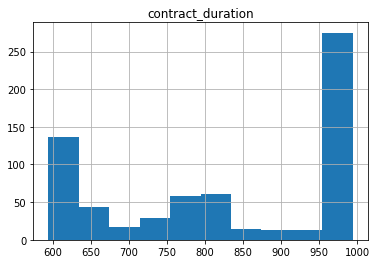

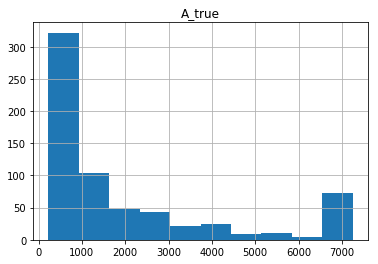

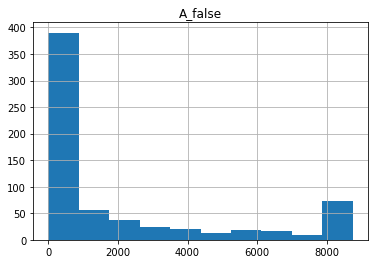

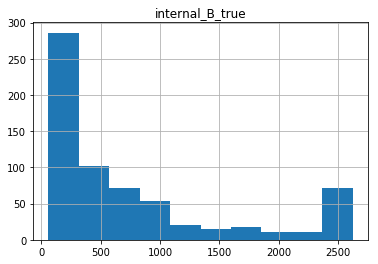

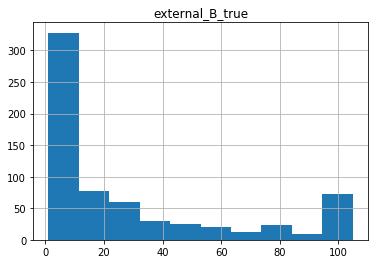

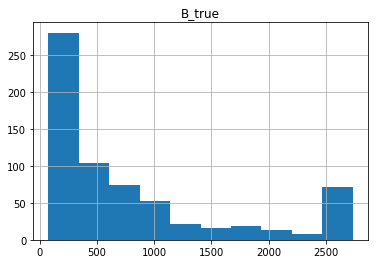

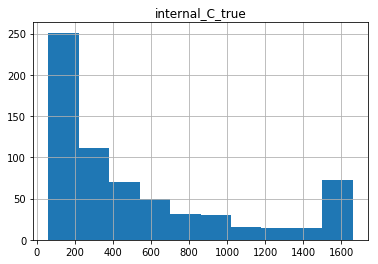

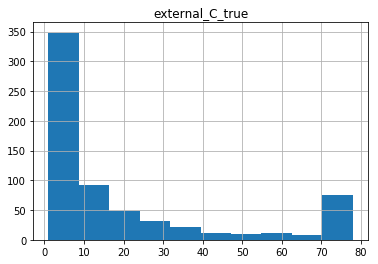

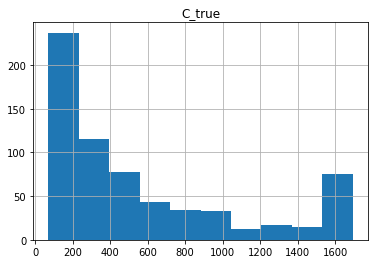

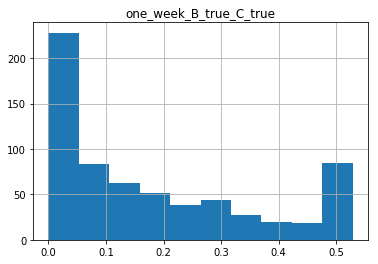

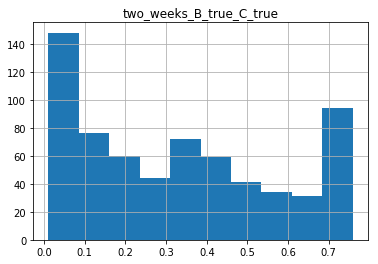

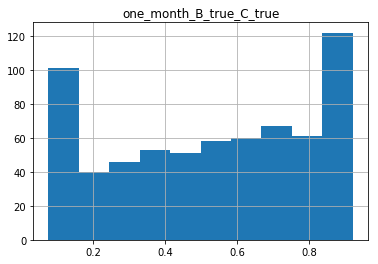

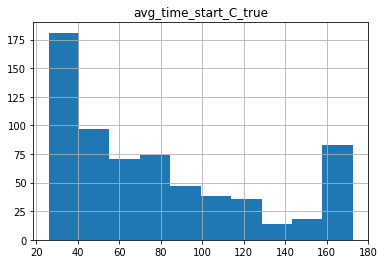

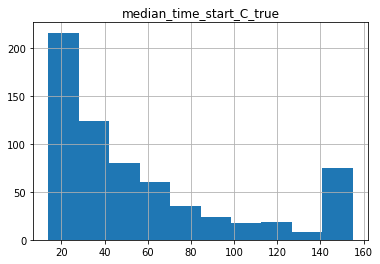

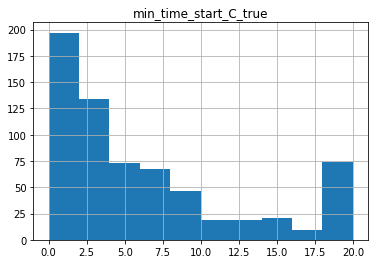

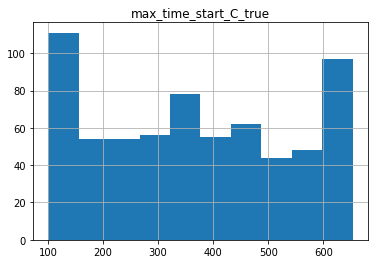

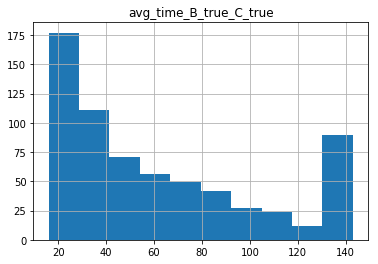

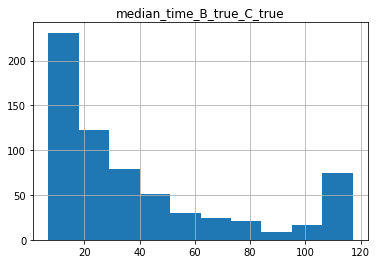

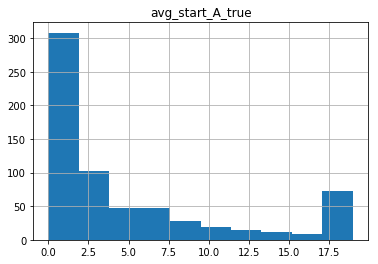

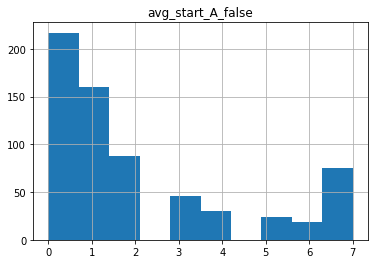

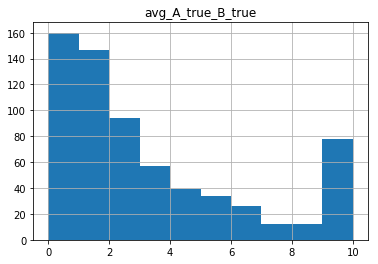

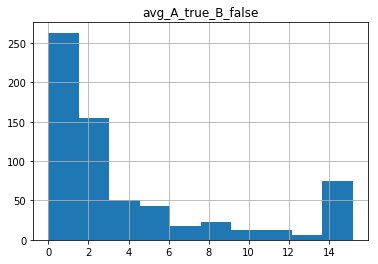

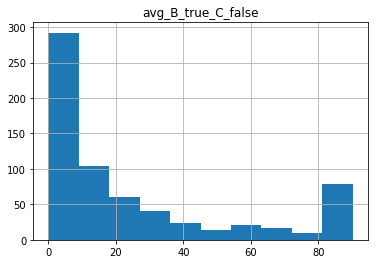

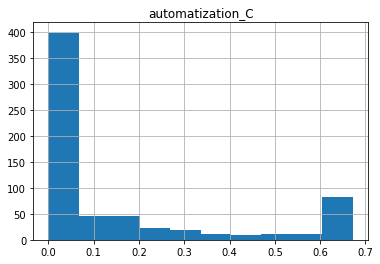

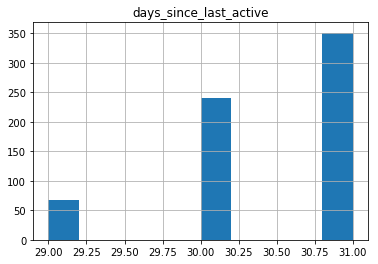

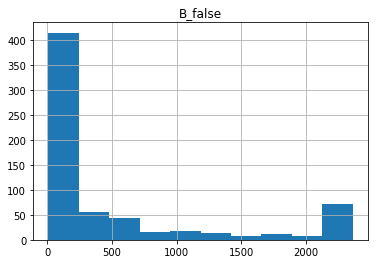

In [25]:
cp.plot_hists(customer,numl)

All the distributions are skewed. In general, machine learning algorithms work better when features' distributions are normal, so I apply the log over each column to see if they become approximately normal, but it didn't help (log distributions were also skewed). So we use the median to replace outliers, which are defined as values with high z-scores (above 2.4): 

In [26]:
def subs_outliers(x):
    std = pd.Series(ss.zscore(x))
    mask = list(std.map(lambda y : True if y >= 2.4 else False))
    #print(x[mask])
    x[mask] = np.median(x)
    return x

customer[numl] = customer[numl].apply(subs_outliers)

## Feature Selection <a class="anchor" id="selection"></a>

### Categorical Features

We need to look at the distribution of categorical features to be able to tell whether they carry relevant information to separate chuning and non-churning cases. Often, when you have a small amount of categorical features, this is more effective and intuitive than performing a Chi-Test or to use the mutual information criterion. First, let's look at data imbalance:

In [27]:
customer.churned.value_counts()

0    567
1     92
Name: churned, dtype: int64

Imbalanced data prevents us from visualising data in an informative way. So let's undersample our data just for visualization:

In [28]:
data = cm.rebalance(customer, 'churned')

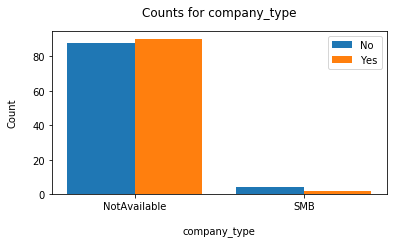

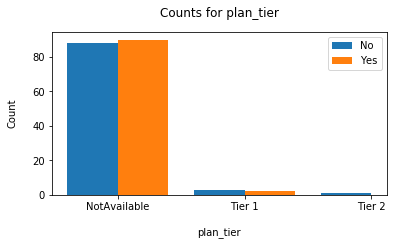

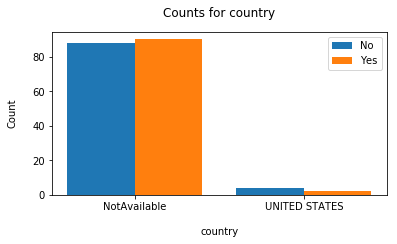

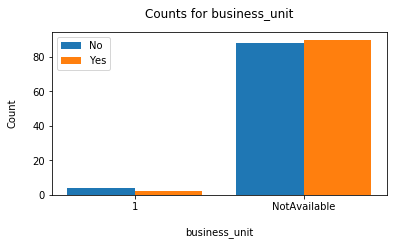

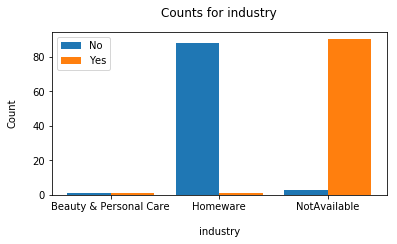

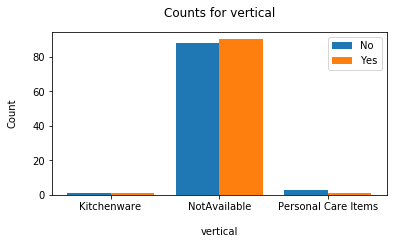

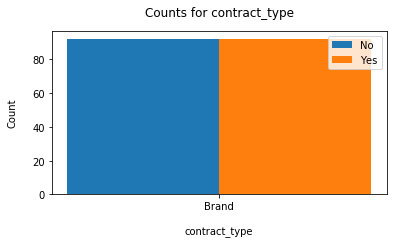

In [29]:
cp.plot_bars(data,catg,'churned')

Only **industry** and **vertical** seem to have some relevance, so we drop the other columns:

In [30]:
customer.drop(['company_type',
                 'plan_tier',
                 'country',
                 'business_unit',
                 'contract_type'],axis=1,inplace=True)
catg = ['industry','vertical']

### Numerical Features

Again, we start with visualizing our data. The heatmap of correlations between every pair of numerical features points to some possibly redundant features:

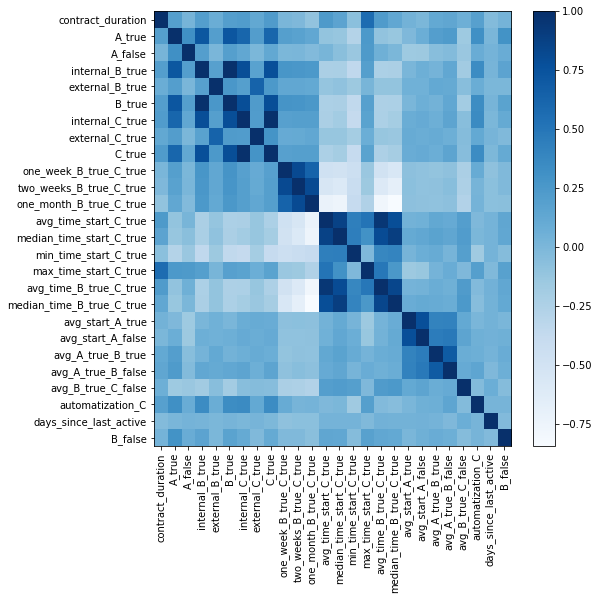

In [31]:
cp.heatmap(customer[numl])

Let's inspect seemingly redundant pairs more closely, to decide which member of each pair we can drop safely. Each line contains a pair:

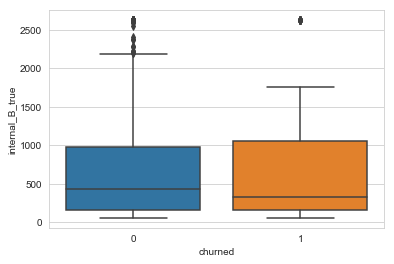

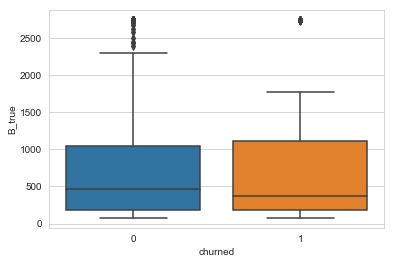

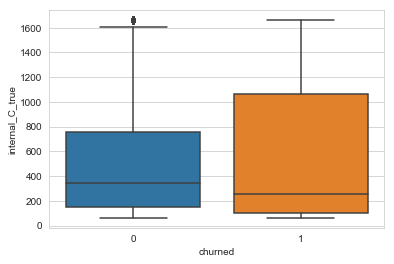

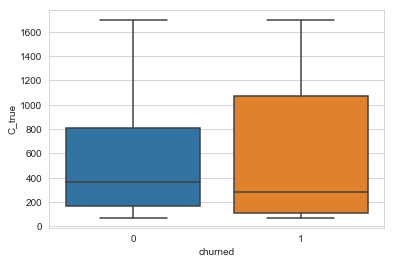

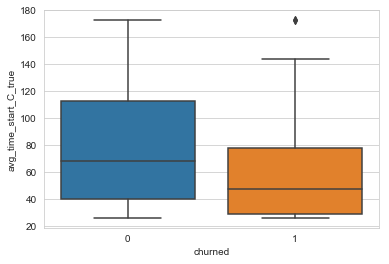

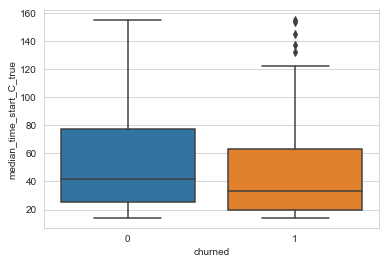

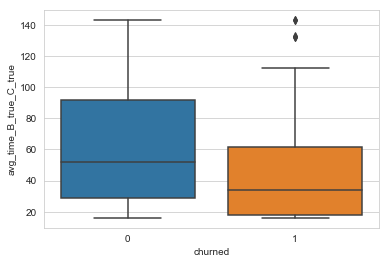

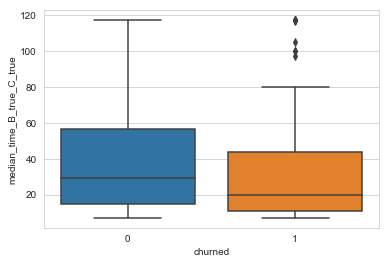

In [32]:
to_inspect = ['internal_B_true','B_true', 
            'internal_C_true', 'C_true', 
            'avg_time_start_C_true','median_time_start_C_true', 
            'avg_time_B_true_C_true', 'median_time_B_true_C_true']

cp.plot_box(customer,to_inspect,'churned')

Visual inspection suggest that the following variables (one of each pair) are slightly less useful to separate classes:

In [33]:
customer.drop(['B_true', 
            'C_true', 
            'median_time_start_C_true', 
            'median_time_B_true_C_true'], axis=1, inplace=True)

Hence numerical features now are:

In [34]:
numl = ['contract_duration', 'A_true', 'A_false', 'internal_B_true',
        'external_B_true', 'internal_C_true', 'external_C_true', 
        'one_week_B_true_C_true', 'two_weeks_B_true_C_true',
        'one_month_B_true_C_true', 'avg_time_start_C_true',
        'min_time_start_C_true',
        'max_time_start_C_true', 'avg_time_B_true_C_true',
        'avg_start_A_true', 'avg_start_A_false',
        'avg_A_true_B_true', 'avg_A_true_B_false', 'avg_B_true_C_false',
        'automatization_C', 'B_false', 'days_since_last_active']

Finally, we use Recursive Feature Elimination with XGBoost to select the 15 most relevant numerical features. That's good practice, because extra features in a arguably shallow dataset could introduce a lot of noise into the model.

In [35]:
y = customer.churned
numl_feats = customer[numl]

scl = pp.StandardScaler()
X_scl = scl.fit(numl_feats)
X_std = pd.DataFrame(X_scl.transform(numl_feats), columns=numl)

rfe = RFE(XGBClassifier(n_estimators=30, random_state=1), n_features_to_select=15)
fit = rfe.fit(X_std, y)

print('Selected Features:')
selected = []

for i in range(len(fit.support_)):
    if fit.support_[i]:
        sel = numl_feats.columns[i]
        selected += [sel]
        print(sel)
        
numl = selected

Selected Features:
contract_duration
A_true
A_false
external_B_true
internal_C_true
external_C_true
one_month_B_true_C_true
avg_time_start_C_true
min_time_start_C_true
max_time_start_C_true
avg_time_B_true_C_true
avg_start_A_false
avg_B_true_C_false
automatization_C
days_since_last_active


Note that XGBoost actually doesn't need scaling. However, it is highly recommended when performing feature selection.

## Training  <a class="anchor" id="traintest"></a>

In this section I finally train my XGBoost model. The first step is to subset *customer*, to retrieve only the selected features. Then, I calculate the weight of each class (the inverse of class frequency) to make up for class imbalance and obtain training (85% of original data) and testing sets (15% of original data). Testing sets will only be used in the next section.

In [36]:
# Subset customer
X = cm.get_dummies(customer[catg + numl], catg)
y = customer[['churned']]

# This is needed for a custom function that performs a nested cross validation
is_numl = X.columns.map(lambda x : True if x in numl else False)
numl_ix = pd.Series(range(X.shape[1]))[is_numl]

# Calculate the weights (needed)
cnts = y.churned.value_counts()
w0 = cnts[1]/len(y)
w1 = cnts[0]/len(y)

# Obtain training and testing sets
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.15, random_state = 10)

### Exploring the Hyperparameter Space  <a class="anchor" id="space"></a>

It's usually impossible to have a preliminary idea of which intervals of hyperparameters to use in fine-tuning if some kind of sweeping is not performed beforehand. So, for each relevant XGBoost parameter, I examine a list of possible values by calculating the Area under the Precision Recall Curve (PR-AUC) over 30 runs for each value. I then fix the value for which PR-AUC was the highest, provided variation in stardard deviations is not too high (yielding unstable results), and proceed with testing values for every other parameter in the same way. The box plots illustrate the distribution of each value in terms of the PR-AUC it induced.


Side note: In this setting, F1 is not available, so I used the next best metric for the problem at hand. F1 is available for nested cross-validation, which is shown in the next section.

[Experiment n_estimators=20] Average Test PR-AUC: 0.9811487999999998
[Experiment n_estimators=30] Average Test PR-AUC: 0.9845824333333335
[Experiment n_estimators=40] Average Test PR-AUC: 0.9862856666666668
[Experiment n_estimators=50] Average Test PR-AUC: 0.9867107666666668
[Experiment n_estimators=100] Average Test PR-AUC: 0.9825223333333336
[Experiment n_estimators=200] Average Test PR-AUC: 0.9784521666666667
[Experiment n_estimators=500] Average Test PR-AUC: 0.9728091333333334


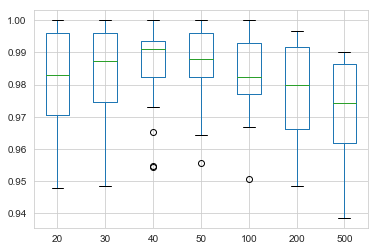

In [37]:
params = {'n_estimators':30, 
          'subsample':1, 
          'colsample_bytree':0.8,
          'colsample_bylevel':1,
          'colsample_bynode':0.5,
          'gamma': 0,
          'learning_rate': 0.2,
          'max_depth': 7,
          'min_child_weight': 1,
          'reg_alpha': 0,
          'reg_lambda': 1,
          'scale_pos_weight':math.floor(cnts[0]/cnts[1])}


ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'n_estimators', [20,30,40,50,100,200,500])

[Experiment gamma=0] Average Test PR-AUC: 0.9862856666666668
[Experiment gamma=1] Average Test PR-AUC: 0.9867528000000002
[Experiment gamma=5] Average Test PR-AUC: 0.9882271333333336
[Experiment gamma=10] Average Test PR-AUC: 0.9849786666666667
[Experiment gamma=15] Average Test PR-AUC: 0.9799627666666668


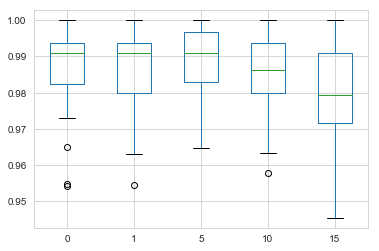

In [38]:
params['n_estimators'] = 40
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'gamma', [0,1,5,10,15])

[Experiment learning_rate=0.05] Average Test PR-AUC: 0.982212666666667
[Experiment learning_rate=0.1] Average Test PR-AUC: 0.9882608000000002
[Experiment learning_rate=0.15] Average Test PR-AUC: 0.9878358000000002
[Experiment learning_rate=0.2] Average Test PR-AUC: 0.9882271333333336
[Experiment learning_rate=0.25] Average Test PR-AUC: 0.9866877666666667
[Experiment learning_rate=0.3] Average Test PR-AUC: 0.9862896333333335
[Experiment learning_rate=0.35] Average Test PR-AUC: 0.9839761
[Experiment learning_rate=0.4] Average Test PR-AUC: 0.9802900666666667


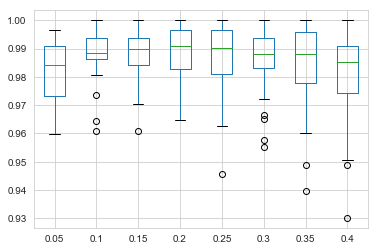

In [39]:
params['gamma'] = 5
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'learning_rate', [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.40])

[Experiment max_depth=3] Average Test PR-AUC: 0.9698718666666666
[Experiment max_depth=6] Average Test PR-AUC: 0.9869742666666668
[Experiment max_depth=9] Average Test PR-AUC: 0.9856903333333336
[Experiment max_depth=18] Average Test PR-AUC: 0.9882381333333335
[Experiment max_depth=36] Average Test PR-AUC: 0.9882381333333335
[Experiment max_depth=72] Average Test PR-AUC: 0.9882381333333335


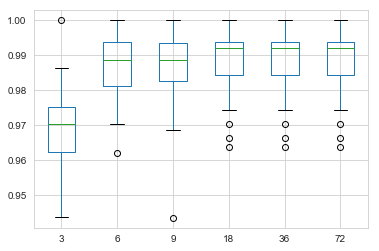

In [40]:
params['learning_rate'] = 0.2
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'max_depth', [3,6,9,18,36,72])

[Experiment min_child_weight=0] Average Test PR-AUC: 0.9859348333333335
[Experiment min_child_weight=1] Average Test PR-AUC: 0.9869742666666668
[Experiment min_child_weight=2] Average Test PR-AUC: 0.9841117000000001
[Experiment min_child_weight=5] Average Test PR-AUC: 0.9814653
[Experiment min_child_weight=20] Average Test PR-AUC: 0.9439370333333332


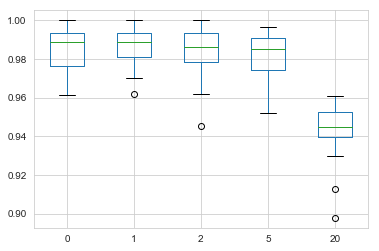

In [41]:
params['max_depth'] = 6
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'min_child_weight', [0,1,2,5,20])

[Experiment reg_alpha=0] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_alpha=0.0001] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_alpha=0.001] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_alpha=0.01] Average Test PR-AUC: 0.9869321000000001
[Experiment reg_alpha=0.1] Average Test PR-AUC: 0.9865978000000001
[Experiment reg_alpha=0.5] Average Test PR-AUC: 0.9853713333333334
[Experiment reg_alpha=1] Average Test PR-AUC: 0.9863408666666665


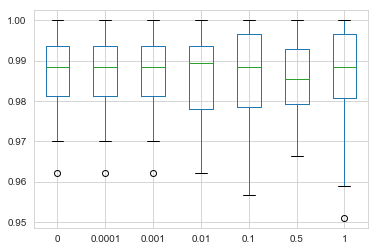

In [42]:
params['min_child_weight'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'reg_alpha', [0,0.0001,0.001,0.01,0.1,0.5,1])

[Experiment reg_lambda=0] Average Test PR-AUC: 0.9867909666666669
[Experiment reg_lambda=0.5] Average Test PR-AUC: 0.9876906666666667
[Experiment reg_lambda=1] Average Test PR-AUC: 0.9869742666666668
[Experiment reg_lambda=2] Average Test PR-AUC: 0.9868845666666668
[Experiment reg_lambda=5] Average Test PR-AUC: 0.9819426
[Experiment reg_lambda=10] Average Test PR-AUC: 0.9777681666666668


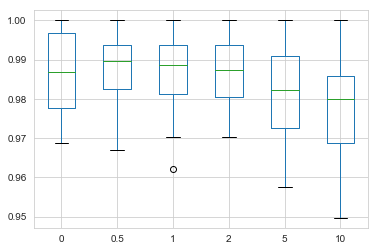

In [43]:
params['reg_alpha'] = 0
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'reg_lambda', [0,0.5,1,2,5,10])

[Experiment subsample=0.1] Average Test PR-AUC: 0.7555224333333332
[Experiment subsample=0.2] Average Test PR-AUC: 0.8649803333333332
[Experiment subsample=0.3] Average Test PR-AUC: 0.9119831333333333
[Experiment subsample=0.4] Average Test PR-AUC: 0.9406346333333333
[Experiment subsample=0.5] Average Test PR-AUC: 0.9533843333333335
[Experiment subsample=0.6] Average Test PR-AUC: 0.9694302
[Experiment subsample=0.7] Average Test PR-AUC: 0.9788429666666668
[Experiment subsample=0.8] Average Test PR-AUC: 0.9816768666666669
[Experiment subsample=0.9] Average Test PR-AUC: 0.9863961666666669
[Experiment subsample=1] Average Test PR-AUC: 0.9876906666666667


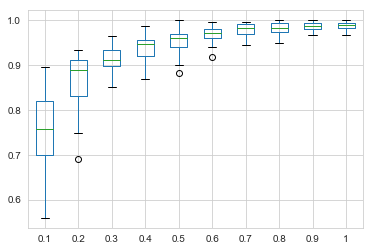

In [44]:
params['reg_lambda'] = 0.5
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'subsample', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

[Experiment colsample_bytree=0.25] Average Test PR-AUC: 0.8999945
[Experiment colsample_bytree=0.5] Average Test PR-AUC: 0.9770496666666667
[Experiment colsample_bytree=0.75] Average Test PR-AUC: 0.9870158333333333
[Experiment colsample_bytree=1] Average Test PR-AUC: 0.9898051333333334


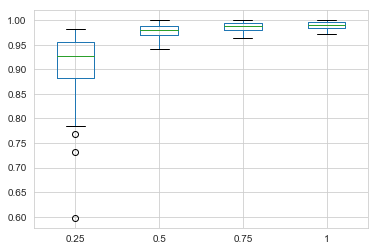

In [45]:
params['subsample'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'colsample_bytree', [0.25,0.5,0.75,1])

[Experiment colsample_bylevel=0.25] Average Test PR-AUC: 0.9050802333333332
[Experiment colsample_bylevel=0.5] Average Test PR-AUC: 0.9597821666666666
[Experiment colsample_bylevel=0.75] Average Test PR-AUC: 0.9773030666666668
[Experiment colsample_bylevel=1] Average Test PR-AUC: 0.9898051333333334


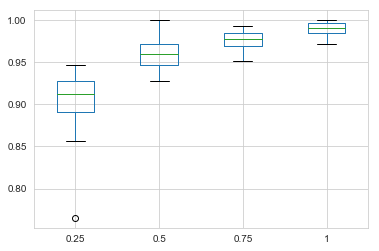

In [46]:
params['colsample_bytree'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'colsample_bylevel', [0.25,0.5,0.75,1])

[Experiment colsample_bynode=0.25] Average Test PR-AUC: 0.9639053666666667
[Experiment colsample_bynode=0.5] Average Test PR-AUC: 0.9898051333333334
[Experiment colsample_bynode=0.75] Average Test PR-AUC: 0.9935787333333335
[Experiment colsample_bynode=1] Average Test PR-AUC: 0.9936390000000004


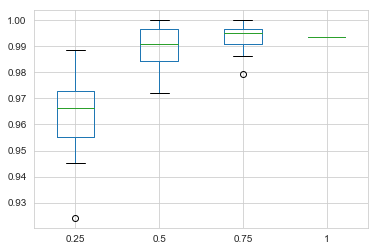

In [47]:
params['colsample_bylevel'] = 1
ca.vary_xgb_params(X_train, X_test, y_train, y_test, params, 'colsample_bynode', [0.25,0.5,0.75,1])

In [48]:
params['colsample_bynode'] = 0.75

### Hyperparameter Tuning  <a class="anchor" id="tuning"></a>

Now that we know the values around which we should search for the best hyparamenters, we run a nested cross-validation over this search space:

In [49]:
space = {
     'n_estimators': [30,40,50],
     'subsample': [1,0.9],
     'colsample_bytree': [1,0.9],
     'colsample_bylevel': [0.9,1],
     'colsample_bynode': [0.9,0.75],
     'gamma': [1,5],
     'learning_rate': [0.15,0.2,0.25],
     'max_depth': [6,7],
     'min_child_weight': [0,1],
     'reg_alpha': [0],
     'reg_lambda': [1,0.5],
     'scale_pos_weight': [6]
}

ca.nested_cross_validation(X_train, y_train, numl_ix, XGBClassifier(random_state=10, n_jobs=-1), space)

>> validation f1 = 0.9, train f1 = 0.97, threshold = 0.25, clf = {'colsample_bylevel': 1, 'colsample_bynode': 0.75, 'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 6, 'subsample': 1}
>> validation f1 = 0.82, train f1 = 0.98, threshold = 0.5, clf = {'colsample_bylevel': 0.9, 'colsample_bynode': 0.75, 'colsample_bytree': 0.9, 'gamma': 1, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 40, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 6, 'subsample': 0.9}
>> validation f1 = 0.85, train f1 = 0.97, threshold = 0.25, clf = {'colsample_bylevel': 0.9, 'colsample_bynode': 0.75, 'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 30, 'reg_alpha': 0, 'reg_lambda': 0.5, 'scale_pos_weight': 6, 'subsample': 1}
>> validation f1 = 0.95, train f1 = 0.97, threshold = 0.75, clf = {'colsa

Results seem great. Mean validation F1 is very high (0.88), suggesting high precision and high recall. F1 is also stable across folds (standard error of 0.04, one order of magnitute smaller than 0.88), meaning we should not have a bad surprise when using the model on the test set.

## Testing  <a class="anchor" id="results"></a>

We chose the configuration that appeared more frequently in the 5 outer folds of the nested cross-validation procedure and fit the model to the training data. Then, we apply it to the test set and print the results.

In [50]:
best_params = {'colsample_bylevel': 1, 
               'colsample_bynode': 0.75, 
               'colsample_bytree': 1, 
               'gamma': 1, 
               'learning_rate': 0.15, 
               'max_depth': 7, 
               'min_child_weight': 0, 
               'n_estimators': 50, 
               'reg_alpha': 0, 
               'reg_lambda': 0.5, 
               'scale_pos_weight': 6, 
               'subsample': 1}

best_clf = XGBClassifier(**best_params, random_state=10, n_jobs=-1)

model = best_clf.fit(X_train, y_train)
probs = model.predict_proba(X_test)
xgb_preds = ca.classify(probs,  0.75)

ca.print_clf_metrics(y_test.churned,xgb_preds)

                 Confusion Matrix
                 Pred. Negative    Pred. Positive
True Negative       82                 0
True Positive        1                16

Accuracy   0.99
ROC-AUC    0.97
 
             Positive      Negative
Num. cases     17          82
Precision    1.00          0.99
Recall       0.94          1.00
F1           0.97          0.99


That's it. The model commited one single mistake in 99 cases. Additionaly, it predicted **all** the churning cases correctly.

# Results Analysis <a class="anchor" id="analysis"></a>

## Important Features <a class="anchor" id="importance"></a>

XGBoost calculates features' importance quite naturally, so we take advantage of this fact to select features to analyse closely and derive insights from. We choose the *gain* metric for this purpose, because it tells us which features brought more information (measured in terms of entropy) on average when assembling the trees (the features that are more precise and effective at separating customers with high probability of churning from customers with low probabilities of churning).

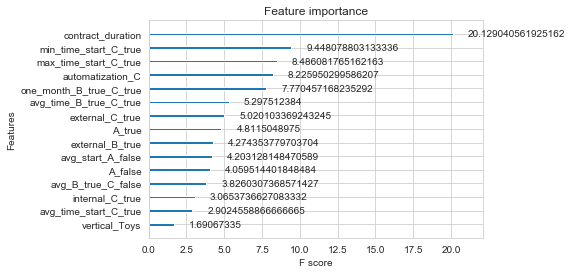

In [51]:
plot_importance(model, importance_type='gain')

In [52]:
important = ['contract_duration', 
             'min_time_start_C_true',
             'max_time_start_C_true',
             'automatization_C',
             'avg_time_B_true_C_true',
             'one_month_B_true_C_true']

We see right away how crucial process C is for customer experience. The only feature that doesn't belong to this process is **contract_duration**. In the next section, I examine the numerical relationships between churning probabilities and these variables. 

## Probabilities and Percentiles <a class="anchor" id="probs"></a>

I use my model to calculate churning probabilities and then binning observations into four categories according to the percentiles they belong. Then I look into scatter plots of **contract_duration** against process-C-related features, colored by groups.

* *Group 0*: Less than equal to .25 (low probability of churning). Blue dots.
* *Group 1*: Greater than .25 and less than or equal to .5 (mid-low probability of churning). Green dots.
* *Group 2*: Greater than .5 and less than or equal to .75 (mid-high probability of churning). Orange dots.
* *Group 3*: Greater than .75 (high probability of churning). Red dots.

I plot **contract_duration** against other variables because, intuitively, it accounts for all sorts of ommited variables that influence churning, being a good proxy for anything we can imagine. The higher the contract duration, the better the knowledge about the product's functionalities, the more efficient the usage, the higher the need for the company's services, etc. When we control for **contract_duration** (i.e. when we keep it fixed), we control for all those ommited factors, so we are able to isolate the effect of process C on churning. 

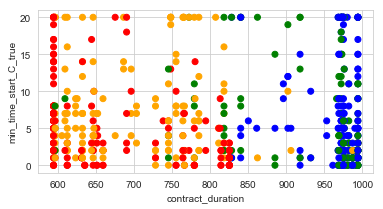

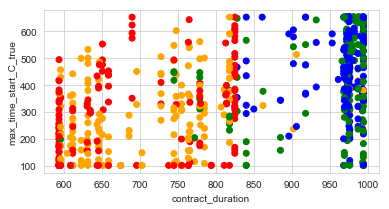

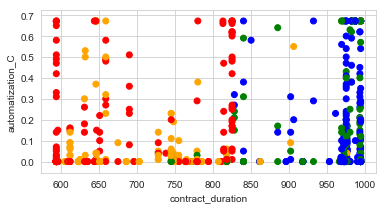

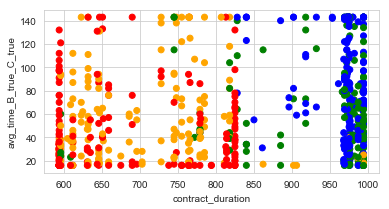

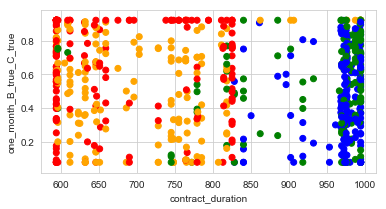

In [53]:
X = cm.get_dummies(customer[catg + numl], catg)
y = customer[['churned']]

probs = model.predict_proba(X)[:,1]
X['prob_churn'] = probs

percs = ['0-.25', '.25-.5', '.5-.75','.75-1']
X['percentile_churn'] = pd.qcut(X['prob_churn'], q = [0, .25, .50, .75, 1], labels = percs)

pairs = [('contract_duration',i) for i in important[1:]]
    
for pair in pairs:
    cp.plot_percentiles(X, pair, X['percentile_churn'],percs)

In my interpretation, red customers (highly disloyal) will probably churn anyway, so it's not worth targeting then. Similarly, blue customers (highly loyal) will probably not churn no matter what the company does, so they shouldn't be subjected to targeting either. The objective of the company should be converting orange (disloyal) and green (loyal) customers into highly loyal customers, that is, moving them to the blue group.

Having that in mind and looking at the graphs, some insights follow. **Holding the duration of contracts fixed**, we have that:

<a id='c1'></a>
* **\[CONCLUSION 1.1\]** The minimum time for a case to be concluded (C = true) separates blues (group 0, highly loyal) from greens (group 1). Greens are frequently associated with higher minimum time and blue with lower. **Loyal** (not highly loyal) customers seem to be more satisfied when they see results earlier, i.e. the faster the first cases are concluded, the happier this type of customer. **Highly loyal** customers seem to be more patient. Causality could also work the other way around. It could be that a longer time to conclude a case is necessary for increased accuracy (less misclassifications), yielding happier customers **among those that are already engaged with the product** (loyal and highly loyal customers).  
* **\[CONCLUSION 1.2\]** The average time for a case to move from B = true to C = true (i.e. from being confirmed as a *mid-risk* case by the user to being classified as an infringement either by the user or by the system) separates blues from greens and oranges. These last groups are associated with lower average times, so it could be that the system is sending too many misclassified cases at early stages. This is expected, since the algorithm is constantly learning. But there might be some benefit to sacrificing speed for more accuracy, as pointed out before. 
* **\[CONCLUSION 1.3\]**  One month **might be too long** for concluding a case: the last two plots mirror each other almost perfectly. Again, causality here might be reversed, since reaching C = true could also be done by the user when validating a case in process C, and more engaged users probably do it faster. 

The next step is to summarize the values of each important feature by group and to check whether differences in means are indeed statistically significant.

In [54]:
def print_summary(feat):
    print('---------------------------------------------------')
    print(feat)
    print('---------------------------------------------------')
    print(X.groupby('percentile_churn')[feat].describe().loc[:,['mean','std','50%']])
    print('---------------------------------------------------')
    
signif_numl = pd.DataFrame(index = important)

def calc_signif(c0, c1, c2, c3):
    p03 = ss.ttest_ind(c0, c3)[1]
    p01 = ss.ttest_ind(c0, c1)[1]
    p12 = ss.ttest_ind(c1, c2)[1]
    p23 = ss.ttest_ind(c2, c3)[1]
    return p03 < 0.01, p01 < 0.01, p12 < 0.01, p23 < 0.01

c = X.percentile_churn
signif_numl = X[important].apply(lambda x : calc_signif(x[c==percs[0]],x[c==percs[1]], x[c==percs[2]], x[c==percs[3]]))

In what follows, I print the tables containing the summaries and below each of them a vector indicating whether 

1. The mean of group 0 (highly loyal) is statistically different from the mean of group 3 (highly disloyal);
2. The mean of group 0 (highly loyal) is statistically different from the mean of group 1 (loyal);
3. The mean of group 1 (loyal) is statistically different from the mean of group 2 (disloyal);
3. The mean of group 3 (disloyal) is statistically different from the mean of group 2 (highly disloyal); 

all at a 1% significance level.

In [55]:
print_summary(important[0])
print(signif_numl[important[0]])

---------------------------------------------------
contract_duration
---------------------------------------------------
                        mean        std    50%
percentile_churn                              
0-.25             968.952128  35.555528  975.0
.25-.5            939.154930  88.886356  976.0
.5-.75            705.335366  93.122209  696.0
.75-1             681.333333  93.376718  646.0
---------------------------------------------------
(True, True, True, False)


No surprise here. Customers with longer contracts tend to churn less. Plus, it's not possible to distinguish highly disloyal and disloyal customers only by looking at the mean contract length.

In [56]:
print_summary(important[1])
print(signif_numl[important[1]])
print("")
print_summary(important[4])
print(signif_numl[important[4]])

---------------------------------------------------
min_time_start_C_true
---------------------------------------------------
                      mean       std  50%
percentile_churn                         
0-.25             6.170213  6.796725  3.0
.25-.5            5.894366  6.725318  3.0
.5-.75            6.725610  6.144803  5.0
.75-1             5.048485  5.492574  3.0
---------------------------------------------------
(False, False, False, True)

---------------------------------------------------
avg_time_B_true_C_true
---------------------------------------------------
                       mean        std   50%
percentile_churn                            
0-.25             79.670213  43.841325  72.0
.25-.5            62.570423  41.631003  51.0
.5-.75            57.109756  38.468378  43.5
.75-1             46.024242  35.182443  32.0
---------------------------------------------------
(True, True, False, True)



* **\[CONCLUSION 2.1\]** On average, the time to conclude a case (C = true) is about 1.5 days lower for highly disloyal customers as compared to customers from other groups. Either they are impatient and were going to churn anyway, or the system is commiting too many mistakes at early stages. This goes in line with [1.1](#c1) and extends it.
* **\[CONCLUSION 2.2\]** The average time for a case to move from B = true to C = true is about 20 days lower for highly disloyal and disloyal customers as compared to loyal and highly loyal customers. This goes in line with [1.2](#c1) and extends it.

In [57]:
print_summary(important[3])
print(signif_numl[important[3]])

---------------------------------------------------
automatization_C
---------------------------------------------------
                      mean       std    50%
percentile_churn                           
0-.25             0.173351  0.230826  0.060
.25-.5            0.198803  0.266502  0.045
.5-.75            0.080183  0.181658  0.000
.75-1             0.174012  0.240317  0.010
---------------------------------------------------
(False, False, True, True)


* [CONCLUSION 2.3](#c23) Disloyal customers (group 2) tend to create more than two times less automation rules to classify a case as an infringement (C = true), as compared to all other groups. 

In [58]:
print_summary(important[5])
print(signif_numl[important[5]])

---------------------------------------------------
one_month_B_true_C_true
---------------------------------------------------
                      mean       std       50%
percentile_churn                              
0-.25             0.443697  0.268555  0.426123
.25-.5            0.548683  0.267827  0.572936
.5-.75            0.516675  0.271672  0.556944
.75-1             0.620687  0.286605  0.672500
---------------------------------------------------
(True, True, False, True)


The table above goes perfectly in line with [1.3](#c13).

### Behavioural Patterns <a class="anchor" id="patterns"></a>

In this section I recover the set of time series per contract to obtain plots of mean and median user behaviour over time. It's important to point out that I don't use the actual timestamps, but the number of interactions of the user with the system. 

As, usual, for each graph or pair of graphs I present some conclusions.

In [59]:
customer_with_id = customer_with_id.dropna(subset = with_nas)
customer_with_id[info_cols] = customer_with_id[info_cols].fillna('NotAvailable')
customer_with_id[numl] = customer_with_id[numl].apply(subs_outliers)

series = pd.concat([customer_with_id[important + ['churned','customer','contractid']],X['prob_churn']],axis=1)

In [60]:
len(series.customer.unique()) == len(series.contractid.unique())

True

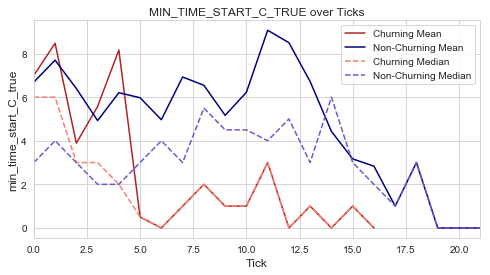

In [68]:
series['tick'] = series.groupby('customer').cumcount()

positive = series.loc[series.churned == 1,:].drop('churned',axis=1)
negative = series.loc[series.churned == 0,:].drop('churned',axis=1)

def plot_cases(column):

    pos_means = positive.groupby('tick')[column].mean()
    neg_means = negative.groupby('tick')[column].mean()
    pos_medians = positive.groupby('tick')[column].median()
    neg_medians = negative.groupby('tick')[column].median()
    
    fig = plt.figure(figsize=(8, 4))
    pos_means.plot(c='firebrick', label='Churning Mean')
    neg_means.plot(c='navy', label='Non-Churning Mean')
    pos_medians.plot(c='salmon', style='--', label='Churning Median')
    neg_medians.plot(c='slateblue', style='--', label='Non-Churning Median')  
    plt.xlabel("Tick", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.legend(fontsize=10)
    plt.title(column.upper() + ' over Ticks')


important = important[1:] 

plot_cases(important[0])

<a id='c31'></a>
* **\[CONCLUSION 3.1\]** Before the 5th interaction, the minimum time to conclude a case is higher among churning customers as compared to non-churning customers. Then it switches abruptly and radically. It might point to the high cost of frustrating users with quick but innacurate predictions after the 5th interaction. It may also suggest that churning customers are not using the product adequately, i.e. configuring inconsistent automation rules that lead them quickly to the final stage, but with wrong predictions.

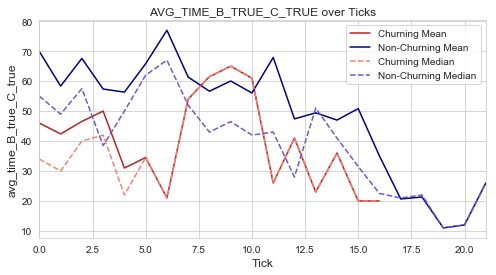

In [62]:
plot_cases(important[3])

<a id='c32'></a>
* **\[CONCLUSION 3.2\]** The average time to conclude a case after it was confirmed as a *mid risk* is consistently higher among churning customers as compared to non-churning customers. It might point to the high cost of frustrating users with quick but innacurate predictions after the cases were labeled as *mid risk*. Again, it may also suggest that churning customers are not using the product adequately, i.e. configuring inconsistent automation rules that lead them quickly to the final stages but with wrong predictions.

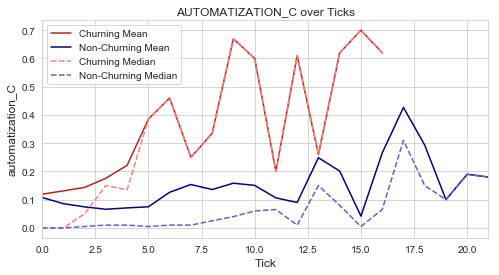

In [63]:
plot_cases(important[2])

* **\[CONCLUSION 3.2\]** This plot might present additional evidence that churning customers are not using the product adequately, i.e. configuring inconsistent automation rules that lead them to the final stage but with wrong matches, as pointed out in [3.1](#c31) and [3.2](#c32). Conversely, it might only indicate that users that are dissatisfied try to create more automation rules to achieve better results.

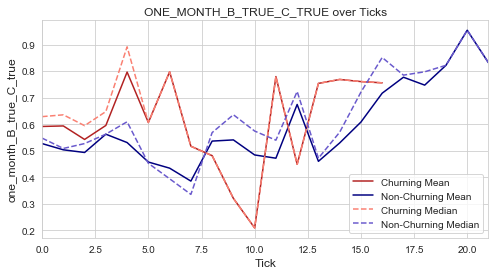

In [64]:
plot_cases(important[4])

For both churning and non-churning customers, the number of cases that take one month to conclude after being labeled as *mid risk* has a decreasing trend at first interactions and at some point this trend reverses. For churning customers the trend reverts later (around the 10th interaction as opposed to 6th). I find this intriguing, but couldn't find a reasonable explanation. 

# Appendix <a class="anchor" id="appendix"></a>

In [65]:
from sklearn.linear_model import LogisticRegression

scl = pp.StandardScaler()
X_scl = scl.fit(X_train[numl])
X_std = X_train.copy()
X_std[numl] = X_scl.transform(X_train[numl])

space = {'C': [0.5, 1,10,20,50,100,200,500,1000],
 'class_weight': [{0:w0,1:w1}],
 'fit_intercept': [True,False],
 'penalty': ['l1','l2']}

ca.nested_cross_validation(X_std, y, numl_ix, LogisticRegression(), space, ts = np.linspace(0.2,0.8,7))

>> validation f1 = 0.26, train f1 = 0.61, threshold = 0.2, clf = {'C': 20, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
>> validation f1 = 0.21, train f1 = 0.58, threshold = 0.2, clf = {'C': 1, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': True, 'penalty': 'l2'}
>> validation f1 = 0.28, train f1 = 0.64, threshold = 0.2, clf = {'C': 1, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
>> validation f1 = 0.27, train f1 = 0.6, threshold = 0.5, clf = {'C': 100, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': True, 'penalty': 'l2'}
>> validation f1 = 0.2, train f1 = 0.57, threshold = 0.4, clf = {'C': 500, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
Mean validation results:
F1: 0.244 (0.034)
AUC: 0.521 (0.036)
Accuracy: 0.293 (0.202)


In [66]:
best_params = {'C': 1, 'class_weight': {0: 0.13960546282245828, 1: 0.8603945371775418}, 'fit_intercept': False, 'penalty': 'l2'}
best_clf = LogisticRegression(**best_params)

X_scl = scl.fit(X_test[numl])
X_std_test = X_test.copy()
X_std_test[numl] = X_scl.transform(X_test[numl])

model = best_clf.fit(X_std, y_train)
probs = model.predict_proba(X_std_test)
lrg_preds = ca.classify(probs,  0.2)

ca.print_clf_metrics(y_test,lrg_preds)

                 Confusion Matrix
                 Pred. Negative    Pred. Positive
True Negative       46                36
True Positive        0                17

Accuracy   0.64
ROC-AUC    0.78
 
             Positive      Negative
Num. cases     17          82
Precision    0.32          1.00
Recall       1.00          0.56
F1           0.49          0.72
